In [1]:
# Input:
path_x_train = '/content/X_train_lag4.npy'
path_y_train = '/content/y_train_lag4.npy'
path_x_val = '/content/X_val_lag4.npy'
path_y_val = '/content/y_val_lag4.npy'
epochs=30
metrics = ['mae']
batch_size=500
model_name='forecaste_lstm.hdf5'
monitor='val_mae'
mode='min'
patience=5
test_score, val_score = 'mae', 'val_mae'

n_features = 6
n_seq = 2
n_steps = 2
dimension = 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [5]:
# Load data (lag 4 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))

In [6]:
print("X_train: ", X_train.shape, "| y_train: ", y_train.shape)
print("X_val: ", X_val.shape, "| y_val: ", y_val.shape)

X_train:  (4619, 4, 6) | y_train:  (4619, 1)
X_val:  (1067, 4, 6) | y_val:  (1067, 1)


In [7]:
# Stacked CNN LSTM architecture
def build_cnn_lstm_model(X_train):
    model = Sequential()
    model.add(
        TimeDistributed(
            Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(None, n_steps, n_features))
          )
    )
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model

In [8]:
def build_conv_lstm_model(X_train):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
    model.add(Flatten())
    model.add(Dense(16))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=opt, metrics=metrics)

    return model

In [9]:
# Set callbacks
def create_callbacks(model_name, monitor, mode, patience):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    return es, checkpoint

# Fit model
def fit_model(model, es, checkpoint, X_train, y_train, X_val, y_val):
    model_history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, es],
        shuffle=False,
        verbose=2
    )
    return model, model_history

# Plot model history
def plot_history(model_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(model_history.history[test_score])
    ax[0].plot(model_history.history[val_score])
    ax[0].set_title(test_score)
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()


# CNN LSTM

In [11]:
# Reshape the X_train to have subsequences
X_train_cnn = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_val_cnn = X_val.reshape((X_val.shape[0], n_seq, n_steps, n_features))
print(X_train_cnn.shape, X_val_cnn.shape)
# Create callbacks
es, checkpoint = create_callbacks('forecaster_cnn_lstm.hdf5', monitor, mode, patience)
# Build model architecture
model_cnn_lstm = build_cnn_lstm_model(X_train_cnn)
# Fit the model
model_cnn_lstm, model_cnn_lstm_history = fit_model(
    model_cnn_lstm, es, checkpoint, X_train_cnn, y_train, X_val_cnn, y_val
)

(4619, 2, 2, 6) (1067, 2, 2, 6)
Epoch 1/30
10/10 - 5s - loss: 1.4450 - mae: 1.0059 - val_loss: 1.7449 - val_mae: 1.0480 - 5s/epoch - 527ms/step
Epoch 2/30
10/10 - 0s - loss: 1.1271 - mae: 0.8757 - val_loss: 1.5883 - val_mae: 0.9885 - 84ms/epoch - 8ms/step
Epoch 3/30
10/10 - 0s - loss: 0.9711 - mae: 0.8043 - val_loss: 1.4792 - val_mae: 0.9459 - 81ms/epoch - 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/30
10/10 - 0s - loss: 0.8820 - mae: 0.7522 - val_loss: 1.4598 - val_mae: 0.9212 - 81ms/epoch - 8ms/step
Epoch 5/30
10/10 - 0s - loss: 0.8141 - mae: 0.6988 - val_loss: 1.4526 - val_mae: 0.8973 - 96ms/epoch - 10ms/step
Epoch 6/30
10/10 - 0s - loss: 0.7803 - mae: 0.6591 - val_loss: 1.4363 - val_mae: 0.8769 - 91ms/epoch - 9ms/step
Epoch 7/30
10/10 - 0s - loss: 0.7728 - mae: 0.6387 - val_loss: 1.4309 - val_mae: 0.8683 - 79ms/epoch - 8ms/step
Epoch 8/30
10/10 - 0s - loss: 0.7708 - mae: 0.6312 - val_loss: 1.4284 - val_mae: 0.8676 - 132ms/epoch - 13ms/step
Epoch 9/30
10/10 - 0s - loss: 0.7668 - mae: 0.6308 - val_loss: 1.4209 - val_mae: 0.8685 - 90ms/epoch - 9ms/step
Epoch 10/30
10/10 - 0s - loss: 0.7619 - mae: 0.6321 - val_loss: 1.4177 - val_mae: 0.8700 - 96ms/epoch - 10ms/step
Epoch 11/30
10/10 - 0s - loss: 0.7575 - mae: 0.6314 - val_loss: 1.4171 - val_mae: 0.8706 - 96ms/epoch - 10ms/step
Epoch 12/30
10/10 - 0s - loss: 0.7537 - mae: 0.6291 - val_loss: 1.4138 - val_mae: 0.8698 - 101ms/

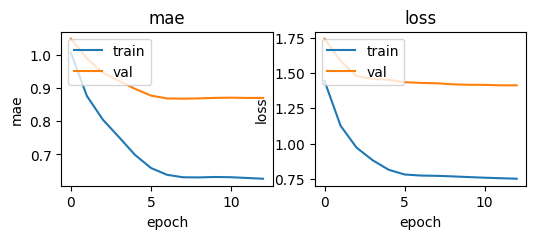

In [12]:
# Plot model history
plot_history(model_cnn_lstm_history, test_score, val_score)

# Conv LSTM

In [13]:
# Reshape the X_train into [samples, subsequences, dimension, timesteps, features]
X_train_conv = X_train.reshape((X_train.shape[0], n_seq, dimension, n_steps, n_features))
X_val_conv = X_val.reshape((X_val.shape[0], n_seq, dimension, n_steps, n_features))
print(X_train_conv.shape, X_val_conv.shape)
# Create callbacks
es, checkpoint = create_callbacks('forecaster_conv_lstm.hdf5', monitor, mode, patience)
# Build model architecture
model_conv_lstm = build_conv_lstm_model(X_train)
# Fit the model
model_conv_lstm, model_conv_lstm_history = fit_model(
    model_conv_lstm, es, checkpoint, X_train_conv, y_train, X_val_conv, y_val
)

(4619, 2, 1, 2, 6) (1067, 2, 1, 2, 6)
Epoch 1/30
10/10 - 7s - loss: 0.9112 - mae: 0.7273 - val_loss: 1.2329 - val_mae: 0.8500 - 7s/epoch - 660ms/step
Epoch 2/30
10/10 - 0s - loss: 0.7323 - mae: 0.6259 - val_loss: 1.1037 - val_mae: 0.8013 - 147ms/epoch - 15ms/step
Epoch 3/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 - 0s - loss: 0.6672 - mae: 0.5766 - val_loss: 0.9932 - val_mae: 0.7550 - 140ms/epoch - 14ms/step
Epoch 4/30
10/10 - 0s - loss: 0.6186 - mae: 0.5534 - val_loss: 0.8564 - val_mae: 0.6997 - 144ms/epoch - 14ms/step
Epoch 5/30
10/10 - 0s - loss: 0.5633 - mae: 0.5335 - val_loss: 0.7497 - val_mae: 0.6533 - 143ms/epoch - 14ms/step
Epoch 6/30
10/10 - 0s - loss: 0.5054 - mae: 0.5053 - val_loss: 0.6475 - val_mae: 0.5995 - 137ms/epoch - 14ms/step
Epoch 7/30
10/10 - 0s - loss: 0.4460 - mae: 0.4700 - val_loss: 0.5809 - val_mae: 0.5547 - 146ms/epoch - 15ms/step
Epoch 8/30
10/10 - 0s - loss: 0.3928 - mae: 0.4382 - val_loss: 0.6034 - val_mae: 0.5524 - 140ms/epoch - 14ms/step
Epoch 9/30
10/10 - 0s - loss: 0.3556 - mae: 0.4155 - val_loss: 0.6381 - val_mae: 0.5590 - 128ms/epoch - 13ms/step
Epoch 10/30
10/10 - 0s - loss: 0.3338 - mae: 0.4009 - val_loss: 0.6164 - val_mae: 0.5440 - 144ms/epoch - 14ms/step
Epoch 11/30
10/10 - 0s - loss: 0.3188 - mae: 0.3909 - val_loss: 0.5984 - val_mae: 0.5308 - 148ms/e

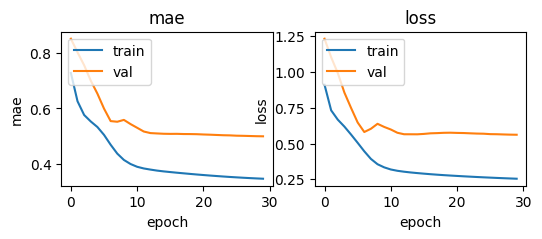

In [14]:
# Plot model history
plot_history(model_conv_lstm_history, test_score, val_score)